In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns

import torch
import torch.nn as nn
from torchmetrics.functional import mean_absolute_percentage_error

In [3]:
pd.set_option("display.max_row", 500)
pd.set_option("display.max_colwidth", 4000)

# Підготовка даних

In [4]:
df = pd.read_csv('data_for_pred.csv')

У користувачів, які двічі скасовували підписку, замінюємо кінцевий таргет на 1 (скасував підписку).

In [5]:
df['Subscription Premium Cancel'] = df['Subscription Premium Cancel'].apply(lambda x: 1 if x==2 else x)

In [6]:
df

,userid,Add Vehicle Success,Add Vehicle Break,Calculator View,Add Payment Method Success,Sign Up Success,Add Payment Method Failed,Wallet Opened,Transaction Refund,Email Confirmation Success,...,Account_History_Transaction_Details_Type_Manual Payment,Account_History_Transaction_Details_Type_Forced Payment,Account_History_Transaction_Details_Type_Refund Transaction,Account_History_Transaction_Details_Type_Pro Plan Subscription,Account_History_Transaction_Details_Type_Promotion,Order_Premium_Membership_False,Order_Premium_Membership_True,Subscription_Premium_Renew_Membership_Type_Monthly,Subscription_Premium_Renew_Membership_Type_Yearly,Add_Vehicle_Failed_Error_Code_ERROR-NaN10
0,0006869712ec9841dc36234bce245203,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,00596aa4edee32815aaf4aad659c484e,1,0,0,2,1,0,0,0,0,...,0,0,0,0,0,0,3,0,0,0
2,007b54670d72df309afd87befcbb63db,1,1,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0136a8eeca5d16ac1a521dd0e27ecec0,1,0,0,1,0,1,0,0,1,...,0,0,0,0,0,0,0,2,0,0
4,01529f53aaba5b512168d432d5650556,1,1,0,1,1,0,0,0,0,...,0,0,0,2,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
807,fd422ac5f5772dc211a97910ea880db2,1,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
808,fd4a11b9abba7352308fabf80c122501,5,2,0,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
809,fd5bc86aa11a1c4b1d17f1e78f50e4a5,2,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
810,fdb8c0dd34b05d1f1b0eb6f1113df175,0,0,1,1,0,0,4,0,0,...,0,0,0,0,0,0,10,0,0,0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 812 entries, 0 to 811
Columns: 152 entries, userid to Add_Vehicle_Failed_Error_Code_ERROR-NaN10
dtypes: float64(3), int64(148), object(1)
memory usage: 964.4+ KB


Прибираємо колонки з кореляцією рівною 1 (у тому випадку, якщо колонки дублюють себе)

In [8]:
indexes = np.where((abs(df.corr()) == 1).sum() >1)

/var/folders/dg/69c5twbs6fqg1qfrxg82bgrh0000gn/T/ipykernel_22383/2766198992.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  indexes = np.where((abs(df.corr()) == 1).sum() >1)


In [9]:
indexes = indexes[0]+1

In [10]:
df.columns[indexes]

Index(['Subscription Premium', 'Account History Transaction Details',
       'Add Vehicle Failed', 'Subscription_Premium_Membership_Type',
       'Account_History_Transaction_Details_Navigated_From',
       'Add_Vehicle_Success_Make_Yamaha', 'Add_Vehicle_Success_Make_Triumph',
       'Add_Vehicle_Failed_Error_Code_ERROR-NaN10'],
      dtype='object')

In [11]:
df = df.drop(['Subscription_Premium_Membership_Type', 'Account_History_Transaction_Details_Navigated_From',
'Add Vehicle Failed', 'Add_Vehicle_Success_Make_Triumph'], axis = 1)

In [12]:
df

,userid,Add Vehicle Success,Add Vehicle Break,Calculator View,Add Payment Method Success,Sign Up Success,Add Payment Method Failed,Wallet Opened,Transaction Refund,Email Confirmation Success,...,Account_History_Transaction_Details_Type_Manual Payment,Account_History_Transaction_Details_Type_Forced Payment,Account_History_Transaction_Details_Type_Refund Transaction,Account_History_Transaction_Details_Type_Pro Plan Subscription,Account_History_Transaction_Details_Type_Promotion,Order_Premium_Membership_False,Order_Premium_Membership_True,Subscription_Premium_Renew_Membership_Type_Monthly,Subscription_Premium_Renew_Membership_Type_Yearly,Add_Vehicle_Failed_Error_Code_ERROR-NaN10
0,0006869712ec9841dc36234bce245203,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,00596aa4edee32815aaf4aad659c484e,1,0,0,2,1,0,0,0,0,...,0,0,0,0,0,0,3,0,0,0
2,007b54670d72df309afd87befcbb63db,1,1,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0136a8eeca5d16ac1a521dd0e27ecec0,1,0,0,1,0,1,0,0,1,...,0,0,0,0,0,0,0,2,0,0
4,01529f53aaba5b512168d432d5650556,1,1,0,1,1,0,0,0,0,...,0,0,0,2,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
807,fd422ac5f5772dc211a97910ea880db2,1,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
808,fd4a11b9abba7352308fabf80c122501,5,2,0,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
809,fd5bc86aa11a1c4b1d17f1e78f50e4a5,2,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
810,fdb8c0dd34b05d1f1b0eb6f1113df175,0,0,1,1,0,0,4,0,0,...,0,0,0,0,0,0,10,0,0,0


Нормалізуємо і навчаємо лінійну регресію з метою відібрати змінні з p-value < 0.05

In [13]:
train_features = list(set(df.columns)-{'userid','Subscription Premium Cancel'})
print(len(train_features))

146


In [ ]:
for name in df.columns:
    print(f'{name} : {df[name].nunique}')

userid : 812
Add Vehicle Success : 6
Add Vehicle Break : 8
Calculator View : 9
Add Payment Method Success : 6
Sign Up Success : 3
Add Payment Method Failed : 5
Wallet Opened : 21
Transaction Refund : 5
Email Confirmation Success : 6
Account Setup Skip : 3
Subscription Premium : 2
Chat Conversation Opened : 19
Account Setup Profile Skip : 4
Account History Transaction Details : 27
Sign Out : 9
Chat Conversation Started : 20
Order : 63
Sign Up Error : 2
Subscription Premium Cancel : 2
Calculator Used : 7
Subscription Premium Renew : 4
Reset Password Set : 2
Transaction_Refund_Amount : 23
user_state_MA : 2
user_state_TN : 2
user_state_CO : 2
user_state_IA : 2
user_state_NM : 2
user_state_CT : 2
user_state_NH : 2
user_state_DE : 2
user_state_CA : 2
user_state_FL : 2
user_state_WI : 2
user_state_WV : 2
user_state_OH : 2
user_state_VA : 2
user_state_PA : 2
user_state_KS : 2
user_state_IN : 2
user_state_KY : 2
user_state_AL : 2
user_state_NJ : 2
user_state_OK : 2
user_state_NC : 2
user_state_

# Лінійна регресія

In [14]:
from sklearn.preprocessing import MinMaxScaler

In [15]:
y = df["Subscription Premium Cancel"]
X = df[train_features].values
X = MinMaxScaler().fit_transform(X)

In [16]:
X.shape

(812, 146)

In [18]:
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
print(f"number of features with p-value < 0.01 - {(model.pvalues<0.01).sum()}")

number of features with p-value < 0.01 - 10


In [19]:
indx_p_values = np.where(model.pvalues<0.05)[0]-1

Дивимось на ознаки, у яких p-value < 0.05 і їхні коефіцієнти в модельці

In [20]:
for i, j in zip(model.params[model.pvalues<0.05], np.array(train_features)[indx_p_values]):
    print(f'{j} : {i}')
    print('\n')

Add_Vehicle_Success_Make_Buick : 0.3666850073729535


Chat Conversation Opened : 1.3032505832860295


Add Payment Method Success : -0.25989784918241204


Add_Vehicle_Success_Make_Lincoln : 0.6522399160906713


Chat Conversation Started : 1.3327272422155165


Add_Vehicle_Success_Make_Oldsmobile : 1.2106516192376642


user_state_NY : -0.1676336040382052


Subscription Premium Renew : -0.1786837304105095


Wallet Opened : 1.093671682522929


user_state_TN : 0.7422143878073315


Account Setup Profile Skip : 0.2256374749752183


Sign Out : 0.7109409772512834


Order_Premium_Membership_True : -0.3420557653572363


Subscription_Premium_Renew_Membership_Type_Yearly : -0.0827113732738203


Subscription_Premium_Renew_Membership_Type_Monthly : -0.15111327264981012


Transaction Refund : 1.1803179942305673


Add_Vehicle_Success_Make_Jaguar : -1.3612160638778035


Calculator View : -0.3579686588102027


Add_Vehicle_Success_Temporary_false : -0.3643493228345238


Add_Payment_Method_Success_Payment_M

In [226]:
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:     Subscription Premium Cancel   R-squared:                       0.493
Model:                                     OLS   Adj. R-squared:                  0.390
Method:                          Least Squares   F-statistic:                     4.788
Date:                         Mon, 06 Feb 2023   Prob (F-statistic):           6.84e-43
Time:                                 16:42:02   Log-Likelihood:                -249.42
No. Observations:                          812   AIC:                             774.8
Df Residuals:                              674   BIC:                             1423.
Df Model:                                  137                                         
Covariance Type:                     nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

Навчаємо RandomForest і дивимось на feature_importances, як додаткова перевірка на важливість ознак

# RandomForest

In [21]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

In [22]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

train_s = []
test_s = []

for n in range(10, 1000, 20):
    
    clf = RandomForestClassifier(n_estimators=n, random_state=42)
    clf.fit(X_train, y_train)
    train_s.append(clf.score(X_train, y_train))
    test_s.append(clf.score(X_test, y_test))

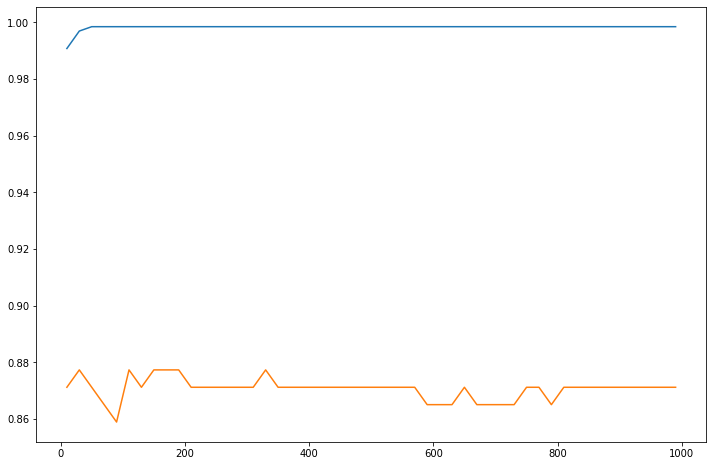

In [23]:
plt.figure(figsize=(12, 8))

plt.plot(range(10, 1000, 20), train_s, label='Train')
plt.plot(range(10, 1000, 20), test_s, label='Test')
plt.show()

Максимізуємо recall, бо нас цікавить тергет 1

In [24]:
from sklearn.metrics import precision_score, recall_score

In [25]:
clf = RandomForestClassifier(n_estimators=600, random_state=42)
clf.fit(X_train, y_train)

print('precision', precision_score(y_test, clf.predict(X_test)))

precision 0.8333333333333334


In [322]:
paramaters = {'max_depth': [None, 3, 4, 5, 6, 7, 8, 9, 10],
             'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10],
             'min_samples_leaf': range(1,6),
             'class_weight': [None, 'balanced', 'balanced_subsample']}

clf_g = RandomForestClassifier(n_estimators=100, random_state=42)
grid = GridSearchCV(clf_g, param_grid=paramaters, scoring='recall', cv=3)

In [323]:
grid.fit(X, y)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
             param_grid={'class_weight': [None, 'balanced',
                                          'balanced_subsample'],
                         'max_depth': [None, 3, 4, 5, 6, 7, 8, 9, 10],
                         'min_samples_leaf': range(1, 6),
                         'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10]},
             scoring='recall')

In [324]:
grid.best_score_

0.8684260852935551

In [325]:
grid.best_params_

{'class_weight': 'balanced',
 'max_depth': 3,
 'min_samples_leaf': 2,
 'min_samples_split': 7}

In [26]:
clf = RandomForestClassifier(n_estimators=600, class_weight='balanced', max_depth=3, min_samples_leaf=2, min_samples_split = 7, random_state=42)
clf.fit(X_train, y_train)

print('accuracy -', clf.score(X_test, y_test))
print('precision -', precision_score(y_test, clf.predict(X_test)))
print('recall -', recall_score(y_test, clf.predict(X_test)))

accuracy - 0.8404907975460123
precision - 0.7068965517241379
recall - 0.82


In [27]:
f_i = clf.feature_importances_

Переглядаємо найбільш важливі ознаки і звіряємо з отриманими ознакми з лінійної регресії

In [28]:
sorted(list(zip(f_i[1:], train_features)), reverse=True)[:24]

[(0.21171404510992015, 'Chat Conversation Started'),
 (0.15424532928088275, 'Chat Conversation Opened'),
 (0.11433478866188412, 'Transaction_Refund_Amount'),
 (0.0947357393584565, 'Transaction Refund'),
 (0.05724501733380125, 'Wallet Opened'),
 (0.04001206781097458, 'Subscription Premium Renew'),
 (0.03586955153296741, 'Subscription_Premium_Renew_Membership_Type_Monthly'),
 (0.023702032235767577,
  'Account_History_Transaction_Details_Type_Auto Payment'),
 (0.02143359226804714, 'Account History Transaction Details'),
 (0.01954748879996832, 'user_state_NY'),
 (0.01949795115276748, 'Order_Premium_Membership_True'),
 (0.018211163769516547, 'Order'),
 (0.011654847580071752,
  'Account_History_Transaction_Details_Type_Pro Plan Subscription'),
 (0.01140701536994315, 'Sign Out'),
 (0.009477042021962123, 'Add_Vehicle_Success_Temporary_false'),
 (0.008907422084838197, 'Account_History_Transaction_Details_Status_Paid'),
 (0.008289792298992106, 'Add_Vehicle_Success_Year_max'),
 (0.008017042593403

# Короткий висновок

Ми використали 2 алгоритми, які досить непогано класифікували наш таргет і таким чином можемо виділити найбільш важливі ознаки. Основним алгоритмом є лінійна регресія по якій ми можемо подивитись вплив фічі на тергет, а RandomForest використали як додаткову перевірку збігу важливих фіч. Більш детальний звіт буде в репезоторії.